In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/torchtorch/'

Mounted at /content/drive


In [ ]:
pip install fastai --upgrade

In [ ]:
import os
os.chdir(path)

In [ ]:
pip install -Uqq fastbook

     |████████████████████████████████| 719 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 30.0 MB/s 


# image collection (with DuckDuckGo)

In [ ]:
from fastbook import *

In [ ]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'https://3.bp.blogspot.com/-ERmaouEbCOw/ThYPiIH9ACI/AAAAAAAAB4E/AzbPHNqSMxE/s1600/Feeling_Grizzly-1600x1200.jpg')

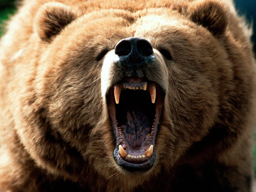

In [ ]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

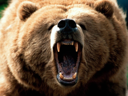

In [ ]:
dest = 'images/grizzly.jpg'
download_url(urls[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest,urls= results)

In [ ]:
fns = get_image_files(path)
fns[:5]

(#5) [Path('bears/grizzly/00000002.jpg'),Path('bears/grizzly/00000008.jpg'),Path('bears/grizzly/00000009.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000007.jpg')]

In [ ]:
isFalied = verify_images(fns)
isFalied

(#0) []

In [ ]:
len(isFalied)

9

In [ ]:
isFalied.map(Path.unlink)

# DataLoaders
전달 받은 여러 DataLoader 객체를 목적에 맞게 학습용과 검증용으로 나누어 저장하는 클래스<br>

필요정보
- 작업 데이터 유형
- 데이터 목록을 가져오는 방법
- 각 데이터에 레이블을 지정하는 방법
- 검증용 데이터셋을 만드는 방법


DataBlock API를 이용해 DataLoaders 생성에 관련된 모든 단계를 완전히 사용자의 상황에 맞게 재정의 할 수 있다.<br>
DataLoaders에 제공되는 데이터는 실제 데이터가 위치한 파일 경로

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders):
        self.loaders = loaders
    def __getitem__(self,i):
        return self.loaders[i]
    trian,valid = add_props(lambda i,self: self[i])

In [ ]:
# DataLoaders를 생성하는 템플릿
bears = DataBlock(blocks=(ImageBlock, CategoryBlock),  # 독립변수와 종속변수
                  get_items = get_image_files,         # 인자로 주어진 경로에 포함된 모든 이미지 목록을 찾아 반환
                  splitter = RandomSplitter(valid_pct=0.2, seed=42),   # 학습과 검증셋 분리
                  get_y = parent_label,     # 데이터셋 레이블링에 쓰일 함수
                  item_tfms = Resize(128))

# 다음과 같이 실제 경로를 지정한다
dls = bears.dataloaders(path)

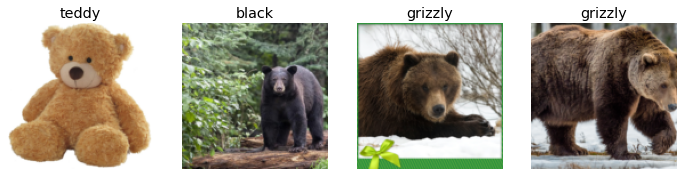

In [ ]:
# 미니배치 : 64
# 하나의 배치 요소중 일부를 화면에 출력할 수 있는 기능을 제공 -> 모델에 주입하기 전에 확인
dls.valid.show_batch(max_n=4,nrows=1)

Resize는 너비와 높이 중 더 작은쪽을 기준으로 나머지를 잘라내는 crop과정이다. 하지만 그 와중에 중요 정보를 잃을 수 있기 때문에 다른 Resize방법들 역시 있다.

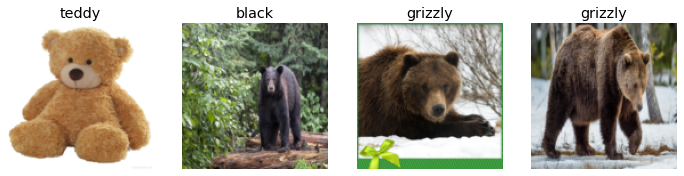

In [ ]:
# 이미지 찌그러뜨리기 -> 비현실적으로 변형되어 실제와 다른 형태를 학습할 수 있음
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

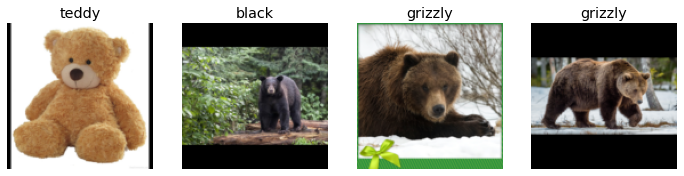

In [ ]:
# zero padding -> 빈 공간이 많아져 모델 계산 처리에 큰 낭비 발생, 실제 필요한 이미지 부분에 대한 유효해상도(effective resolution)가 낮아짐
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

각각의 방법들이 문제가 있으므로 실전에서는 보통 이미지의 특정 부분을 무작위로 선택하여 잘라내는 방식을 사용 <br>= 에포크마다 무작위로 각 이미지의 다른 부분을 선택<br> => 모델이 각 이미지의 서로 다른 위치에서 드러난 특징에 집중하여, 다양성을 인식할 수 있는 방향으로 학습되는 기회를 제공 + 같은 대상을 찍더라도 사진마다 약간씩 다른 방식으로 대상을 표현한다는 실질적인 이미지의 특징을 반영하기도 함

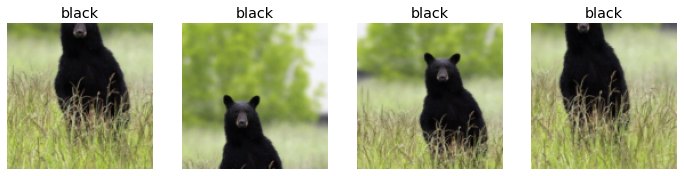

In [ ]:
bears = bears.new(item_tfms = RandomResizedCrop(128, 
                                               min_scale=0.3   # 매번 이미지의 얼마나 많은 영역을 선택할 것인지를 결정
                                               ))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1,unique=True)

## 데이터 증강
- 회전(rotation), 뒤집기(flipping), 원근 뒤틀기(perspective warping), 명도(brightness) 바꾸기, 채도(contrast) 바꾸기

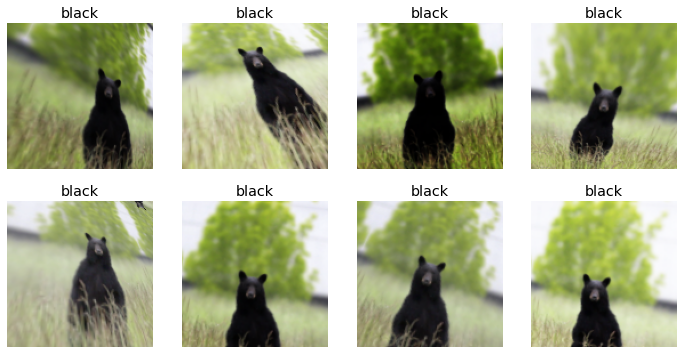

In [ ]:
bears = bears.new(item_tfms = Resize(128),
                  batch_tfms = aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2,unique=True)

# 모델 훈련과 훈련된 모델을 이용한 데이터 정리

In [ ]:
bears = bears.new(item_tfms = RandomResizedCrop(224,min_scale=0.5),
                  batch_tfms = aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.391937,0.183650,0.054054,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.247811,0.151073,0.027027,00:34
1,0.168856,0.159583,0.018018,00:36
2,0.133446,0.164336,0.027027,00:34
3,0.105958,0.149887,0.018018,00:35


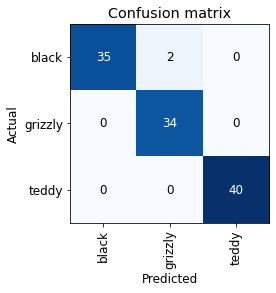

In [ ]:
# 검증용 데이터셋에 대한 confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

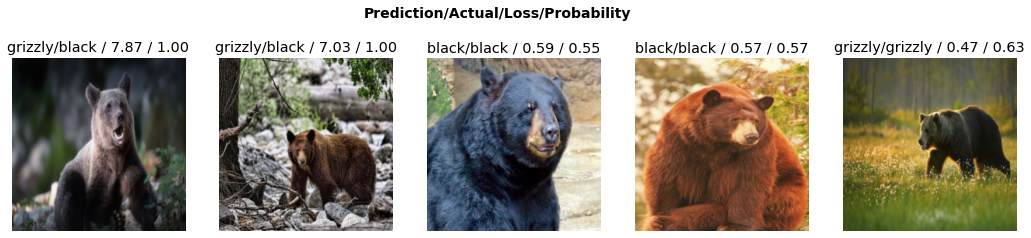

In [ ]:
# 가장 손실이 높은 이미지를 보여준다.
interp.plot_top_losses(5,nrows=1,figsize=(18,4))

현재 이미지들은 duckduckgo를 이용하고 있으나 bing이미지 검색등을 기준으로 데이터를 수집한 경우 라벨링 자체가 잘못 됐을 수 있다.

모델을 학습하기 전에 말끔히 정리하는 것이 좋다. 사전학습된 모델을 사용하면 데이터의 문제를 더 쉽고 빠르게 찾아낼 수 있으므로, 간단한 모델을 빠르게 학습시켜 구축한 다음, 이를 데이터의 정리 작업에 활용하는 것이 일반적으로 좋다.

In [ ]:
# fastai의 기능, 가장 loss가 큰 순서대로 정렬된 이미지 확인 -> index반환
cleaner = ImageClassifierCleaner(learn)
cleaner

# 모델을 온라인 애플리케이션으로 전환하기
## 추론에 모델 사용
export 메서드를 사용하여 모델의 구조와 파라미터를 저장 + DataLoaders 생성 방법의 정의까지도 저장

In [ ]:
learn.export(fname = os.path.join(os.getcwd(),'export.pkl'))

In [ ]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# 학습 대신 예측에 사용하는 것을 추론(inference)라고 부른다.
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.9498e-04, 9.9975e-01, 5.5314e-05]))

In [ ]:
# dls 속성으로 실제 DataLoaders에도 접근 가능
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## 모델로 노트북 애플리케이션 만들기
- IPython 위젯 (ipywidget) -> javascript와 python을 함께 묶어 웹 브라우저상에서 파이썬을 사용할 수 있도록 만들어주는 GUI 구성요소, 단 사용자가 직접 주피터 노트북을 실행해야하는 단점이 있음
- Voila -> 사용자가 주피터 노트북을 전혀 사용하지 않더라도 IPython 위젯으로 구성된 애플리케이션에 접근할 수 있게 만들어주는 시스템

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.7393')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
# click event handler
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
from ipywidgets import VBox

In [ ]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

## 노트북을 실제 애플리케이션으로 바꾸기